In [1]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx
import timeit
import itertools
import pandas as pd
from tqdm import tqdm_notebook


from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.optimization.ising import max_cut, tsp, common
from qiskit.aqua.algorithms import VQE, ExactEigensolver, QAOA
from qiskit.aqua.components.optimizers import SPSA, ADAM
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.qasm import pi

from qiskit.optimization.ising import max_cut

from docplex.mp.model import Model
from qiskit.optimization.ising import docplex

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
from qiskit import IBMQ
provider = IBMQ.load_account()

In [2]:
class circuits:
    def __init__(self, qbits):
        self.qbits = qbits
        self.circ = QuantumCircuit(qbits, qbits)
        for i in range(qbits):
            self.circ.h(i)
    
    def mixer(self, beta, qbit):
        self.circ.u3(2*beta, -pi/2, pi/2, qbit)
        
    def separator(self, gamma, qbit0, qbit1):
        self.circ.cnot(qbit0,qbit1)
        self.circ.u1(-gamma,qbit1)
        self.circ.cnot(qbit0,qbit1)
        
    def measure(self):
        for i in range(self.qbits):
            self.circ.measure(i,i)

In [36]:
class maxcut:
    def __init__(self, G):
        self.G = G
        self.n = len(G)
        
        
    def _build_circuit(self, beta, gamma):
        depth = len(beta)
        self.circuit = circuits(self.n)

        for i in range(depth):
            for (node0, node1) in self.G.edges:
                self.circuit.separator(gamma[i], node0, node1)
            for node in range(self.n):
                self.circuit.mixer(beta[i],node)

        self.circuit.circ.measure(list(np.arange(self.n)), list(np.arange(self.n)))

        
    def draw(self):
        pos = nx.spring_layout(self.G)
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(self.G, node_size=600, alpha=.8, ax=default_axes, pos=pos)
        plt.show()
        
        
    def _solve(self, print_counts = False):
        backend_sim = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit.circ, backend_sim, shots=self.sims)

        # Grab the results from the job.
        self.result_sim = job_sim.result()
        self.counts = self.result_sim.get_counts(self.circuit.circ)
        if print_counts:
            print('The count of each state:', self.counts)
        #return self.counts
        
        
    def _get_value(self, state):
        state = state[::-1]
        return max_cut.max_cut_value(np.array(list(state), dtype= np.int), nx.adjacency_matrix(self.G).toarray())
    
        
    def _expect_value(self, beta, gamma):
        #given beta and gamma, build a new circuit and solve it
        if beta is None:
            pass
        else:
            self._build_circuit(beta, gamma)
            self._solve()
        exp_v = 0
        for (s, i) in self.counts.items():
            exp_v += i*self._get_value(s)
        return exp_v/sum(self.counts.values())

    
    def _grad(self, beta, gamma):
        d_beta = np.zeros_like(beta)
        d_gamma = np.zeros_like(gamma)
        for i in range(len(beta)):
            new_beta = np.copy(beta)
            new_beta[i] += self.delta
            
            d_beta[i] = self._expect_value(new_beta, gamma)-self.training_value[-1]

        for i in range(len(gamma)):
            new_gamma = np.copy(gamma)
            new_gamma[i] += self.delta
            d_gamma[i] = self._expect_value(beta, new_gamma)-self.training_value[-1]

        return d_beta/self.delta, d_gamma/self.delta

    
    def train(self, depth, train_iter, opt_rounds = 25, sims = 100000, learning_rate = 0.02):
        self.learning_rate = learning_rate
        self.delta = 10**(-2)
        self.sims = sims
        self.training_values = np.zeros([train_iter, opt_rounds+1])
        self.betas = np.zeros([train_iter, depth])
        self.gammas = np.zeros([train_iter, depth])
        
        #Decay
        decay1 = 0.9
        decay2 = 0.999
        eps = 10**(-8)
        
        # start points of beta and gamma
        for j in range(train_iter):
            self.beta = np.random.random_sample(depth)*np.pi*2
            self.gamma = np.random.random_sample(depth)*np.pi
            self.training_value = [self._expect_value(self.beta, self.gamma)]
            #1st moment vector
            m_beta = 0
            m_gamma = 0

            #2nd moment vector
            v_beta = 0
            v_gamma = 0

            #bias errors
            m_error_beta = 0
            m_error_gamma = 0
            v_error_beta = 0
            v_error_gamma = 0

            for i in range(opt_rounds):
                #Remember old parameters
                old_beta = self.beta
                old_gamma = self.gamma

                #Find gradient
                d_beta, d_gamma = self._grad(self.beta, self.gamma)

                #Update 1st and 2nd moment vectors
                m_beta = decay1*m_beta +(1-decay1)*d_beta
                m_gamma = decay1*m_gamma + (1-decay1)*d_gamma
                v_beta = decay2*v_beta +(1-decay2)*np.square(d_beta)
                v_gamma = decay2*v_gamma + (1-decay2)*np.square(d_gamma)

                #bias error 1st and 2nd moment vectors
                m_error_beta = m_beta/(1-decay1**(i+1))
                m_error_gamma = m_gamma/(1-decay1**(i+1))
                v_error_beta = v_beta/(1-decay2**(i+1))
                v_error_gamma = v_gamma/(1-decay2**(i+1))            

                #update parameters
                for l in range(depth):
                    self.beta[l] += self.learning_rate*m_error_beta[l]/(np.sqrt(v_error_beta[l])+eps)
                    self.gamma[l] += self.learning_rate*m_error_gamma[l]/(np.sqrt(v_error_gamma[l])+eps)
                self.training_value.append(self._expect_value(self.beta, self.gamma))
            self.training_values[j] = self.training_value
            self.betas[j] = self.beta
            self.gammas[j] = self.gamma
        
        m = np.argmax(self.training_values[:,-1])

        beta = self.betas[m]
        gamma = self.gammas[m]
        expect_value = self._expect_value(beta, gamma)

        return expect_value
    
    
    def learning_curve(self):
        m = np.argmax(self.training_values[:,-1])
        curve = self.training_values[m]
        plt.plot(curve)
        plt.ylabel('Expectation value')
        plt.xlabel('Optimizer round')
        plt.title('Estimated expectation value outcome per round')
        plt.show()
    
    
    def heatmap(self, p, beta_range = [0, np.pi], gamma_range = [0, 2*np.pi], n_gamma = 10, n_beta = 5):
        #heatmap of p-th layer
        new_gamma = np.copy(self.gamma)
        new_beta = np.copy(self.beta)
        gmin, gmax = gamma_range
        bmin, bmax = beta_range
        exp_value = np.zeros([n_gamma, n_beta])
        for i in range(n_gamma):
            for j in range(n_beta):
                new_gamma[p] = np.linspace(gmin, gmax, n_gamma)[i]
                new_beta[p] = np.linspace(bmin, bmax, n_beta)[j]
                exp_value[i,j] = self._expect_value(new_beta, new_gamma)
        #Fancy expectation heatmap
        plt.figure(dpi = 100)
        plt.imshow(exp_value,extent=[0,1,0,2]);
        plt.ylabel(r'$\beta/\pi$')
        plt.xlabel(r'$\gamma/\pi$')
        plt.colorbar()
        plt.show()
        
        
    def bar_plot(self, bars, title = None):
        counts = self.counts
        newcounts = sorted(counts.items(), key = lambda x:(x[1], x[0]), reverse=True)
        plt.figure(figsize=(20,10))
        plt.bar(range(min(len(counts),bars)), np.array(newcounts)[0:bars,1].astype(int)/self.sims, align='center')
        plt.xticks(range(min(len(counts),bars)), list(np.array(newcounts)[0:bars,0]))
        plt.xlabel('Measured Bitstring')
        plt.ylabel('Probability')
        plt.title(title)
        plt.show()

C:\Users\Shawn\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


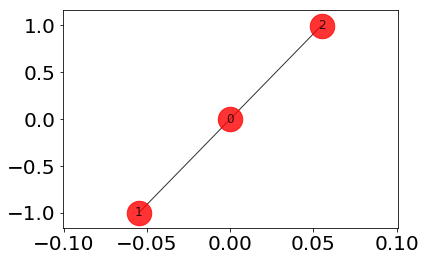

In [37]:
#some fancy graph
#G = nx.Graph([(0,1),(0,2),(0,3),(1,2),(1,3),(0,4),(2,4),(3,4),(2,5),(4,5),(1,6),(6,5)])

#nice testing graph
#G = nx.Graph([(0,1),(1,2),(1,3),(0,2),(2,4),(1,4)])

#Butterfly
#G = nx.Graph([(0,1),(1,2),(2,0),(0,3),(3,4),(4,0)]) 

#Star
G = nx.Graph([(0,1),(0,2)])

mc = maxcut(G)
mc.draw()

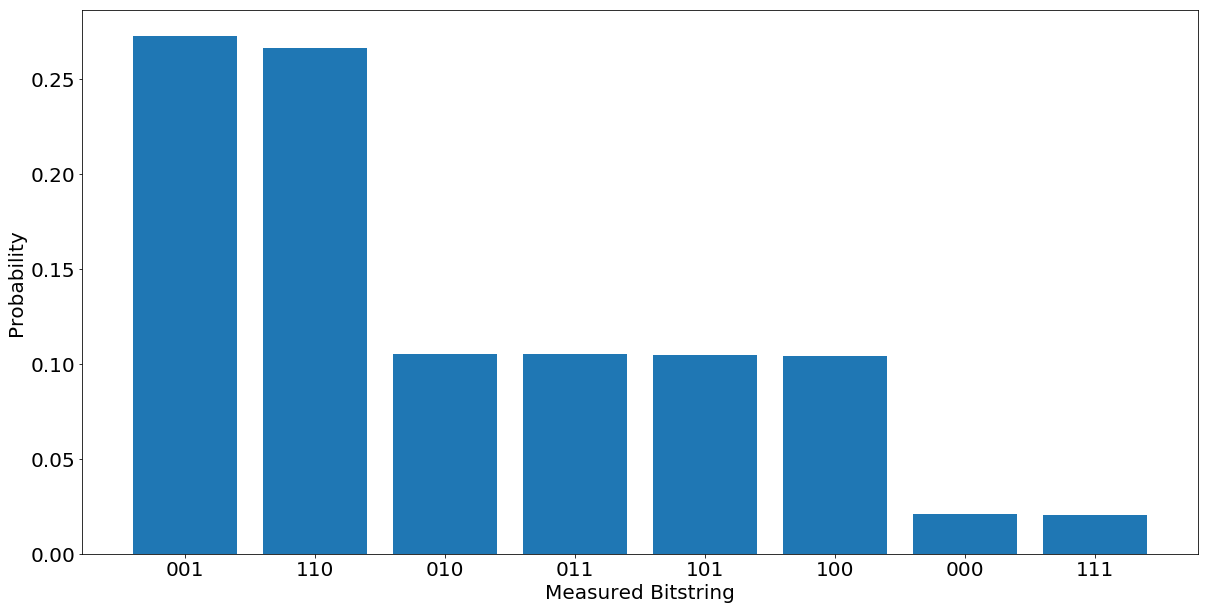

In [38]:
_ = mc.train(1, 5)
mc.bar_plot(8)